# Optimising Spark
© Explore Data Science Academy

## Learning objectives
By the end of this train, you will:
* understand how to scale Spark for large workloads;
* understand and apply caching and persistence of data; 
* understand and defend how to use clusters for running Spark applications, with specific reference to Amazon EMR or Azure Databricks; and
* apply the SparkUI.

## 1. Understand how to scale Spark for large workloads
In this section, we will have a deeper look into Spark configurations and advanced configurations. When optimising the performance of your Spark application, there are typically three levels at which performance can be improved: the Spark driver, the executor, and the shuffle service that shuffles data between executors. All of the below optimisations will touch on one of the three levels of optimisation.

### How to set and retrieve Spark configurations

Spark has hundreds of settings that can be configured to change the behaviour of the Spark processing engine, and these can be changed to specifically suit your workload, be it on the Gigabyte or Petabyte scale. These settings are called Spark configurations. 

There are three ways in which Spark configurations can be set. The first is through configuration files that reside in the `$SPARK_HOME/conf` directory, the second through the Spark Shell, and the third is to specify them directly in the Spark application or on the command line when submitting Spark jobs. 

Let's have a quick look at the templates that can be found in `$SPARK_HOME/conf`.

> 💡 &nbsp; **Note**
>
> For this to work, you need to have installed spark manually as described at the start of the sprint and you should have a `$SPARK_HOME` variable defined in your shell environment. If you have only installed **pyspark** using anaconda. You will not be able to execute the two bash commands, you can however skip this and proceed to **changing the configuration within the Spark application.**


In [1]:
%%bash

# First list the contents of the conf directory.
#ls $SPARK_HOME/conf

Default Spark configurations are defined in `spark-defaults.conf.template` within the same directory. Let's have a look at some of the default configurations:

In [2]:
%%bash

#cat $SPARK_HOME/conf/spark-defaults.conf.template

To change any of these, just uncomment the lines in the above file and remove `.template` from the file name, and Spark will use the configuration. 

We will illustrate how to perform the third method, **changing the configuration within the Spark application**, in more detail. We start, again, by setting up our environment:

In [6]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Set up a SparkSession using the default method.
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/29 14:34:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/07/29 14:34:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/07/29 14:34:18 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


The above method is our default for starting a Spark application. But, instead of using the default, let's rather build a SparkSession with the custom configuration specified. Below we specify:

- the number of shuffle partitions;
- the maximum memory allocated to the executors;
- the Spark driver, with all available cores; and
- the name of the Spark application.


In [13]:
spark = SparkSession.builder\
  .config("spark.sql.shuffle.partitions", 5)\
  .master("local[*]")\
  .appName("SparkConfig")\
  .getOrCreate()
# spark = SparkSession.builder\
#   .config("spark.sql.shuffle.partitions", 5)\
#   .config("spark.executor.memory", "8g")\
#   .master("local[*]")\
#   .appName("SparkConfig")\
#   .getOrCreate()

Alternatively, configurations can be retrieved or set after the session has been set up.


In [14]:
spark.conf.get("spark.sql.shuffle.partitions")

'5'

In [15]:
spark.conf.set("spark.sql.shuffle.partitions", 10)

Let's check if the change comes through:

In [16]:
spark.conf.get("spark.sql.shuffle.partitions")

'10'

It is important to note that, when setting these configurations, the order of precedence is the same as listed above. First, those specified in `$SPARK_HOME`, then those on the command line, and finally, those in the Spark application.

### Resource allocation within Spark
Instead of specifying static limits for the resources that are allocated to jobs, you can allow resources to be allocated dynamically. This is especially useful when sharing a cluster with other users, where you do not want to use all of the resources until you need it. 

Dynamic cluster configuration allows scaling the number of workers based on workload. 

Below are some of the configurations that can be set:

```
spark.dynamicAllocation.enabled=true 
spark.dynamicAllocation.minExecutors=2
spark.dynamicAllocation.maxExecutors=20
spark.dynamicAllocation.schedulerBacklogTimeout=1m
spark.dynamicAllocation.executorIdleTimeout=2min
```

- The first config enables dynamic resource allocation.
- The second config specifies the minimum number of executors.
- The third config specifies the maximum number of executors.
- The fourth config specifies the time waited before more resources are allocated to a specific process, for example, here we set it to 1 minute, meaning if a specific job does not complete within 1 minute, more executors will be allocated to that job.
- The final config is the opposite, specifying the period after which idle executors will be removed from the job.

Running Spark within a managed environment also allows for additional optimisation in this area. Databricks deployed on Microsoft Azure, AWS, or GCP is a fully managed Spark instance, with accompanying clusters attached. Within this service, in addition to the Spark configuration, it is also possible to allow for auto-scaling of managed clusters. While a complete overview of Databricks and Databricks clusters is beyond the scope of this train, we provide a short overview as Databricks is becoming a prominent tool for running Spark in the cloud. 

[Databricks clusters](https://docs.databricks.com/clusters/index.html) are sets of resources and configurations to run your workloads on. Generally, code is run as notebooks but can also be run as jobs in a more scripted manner. Notebooks are normally attached to an all-purpose cluster, which allows for running interactive queries (executing a notebook very similar to this notebook). Where jobs are run on job clusters, which are provisioned once a job is requested to run, the job is run and then shut down once the job completes. To learn more about Databricks, [try it for free](https://databricks.com/try-databricks).


AWS also provides [Amazon EMR](https://docs.aws.amazon.com/emr/index.html), which is a managed cluster infrastructure service on which Spark, Hadoop, Hive, and other big data frameworks can be configured to run. 


### Memory allocation
Within Spark, memory allocation is separated into four types: execution (shuffle) memory, storage (user) memory, reserved memory, and a memory buffer per executor. 

Execution memory is used for shuffles, joins, sorts, and aggregations. This is the largest fraction within the memory config and is 0.6 by default. Shuffle and map operations that are tuned inefficiently may lead to writing and reading from local disks, resulting in high I/O loads and inefficiency. 

Storage memory is used for caching user data structures and partitions derived from DataFrames.

Reserved memory is the easiest of the three and is a proportion of memory reserved to prevent out of memory (OOM) errors. This is set to a default value of 300MB. This section of memory is also allocated to store Spark internal objects. 

A memory buffer can be allocated for each of the executors in a Spark cluster. This memory is specifically for things like virtual machine overheads and other native overheads. 

Let's see what the current setting of our execution memory is.

In [17]:
spark.conf.get("spark.executor.memory")

'8g'

### Parallelism and execution

Spark is great at running multiple tasks in parallel. Most of this is enabled by how Spark reads data into memory. Spark reads the data into memory in chunks, also called partitions. Each of the partitions is a subset of the data, and the same set of calculations can be performed on each partition in parallel. This also means that each parallel execution (in most cases) can be seen as independent and, thus, can scale out without a fixed limit. The creators of Spark calls this _embarrassingly parallel_.

So, partitions have a big influence on the degree of parallelism, since each partition has to be processed by a task that will be scheduled on a thread on a core of the central processing unit (CPU) (this is generally referred to as the executor) on which the Spark application is running. 
If your CPU has more than one core, which can be hyper threaded, you would want to have at least a couple of partitions to make sure that all the cores are kept busy processing data and are not sitting idle while others are still performing calculations on a part of the data.

Thus, as a rule of thumb, it is better to have more partitions than there are cores on your machine. 


<p align="center">
<img src="https://github.com/Explore-AI/Pictures/blob/c9898b18f293bf350241e158f32a1f2199d5a0bd/data_engineering/transform/optimising_spark/low_parallelism.jpg?raw=True",
     alt="Low parallelism",
     style="padding-bottom=0.5em",
     width=800px/>
<br>
<em> Figure 1. Execution with few partitions and a low level of parallelism. Parallelism is limited to the number of partitions, and any available cores outnumbering the partitions will sit idle. </em>
</p>

<p align="center">
<img src="https://github.com/Explore-AI/Pictures/blob/c9898b18f293bf350241e158f32a1f2199d5a0bd/data_engineering/transform/optimising_spark/high_parallelism.jpg?raw=True",
     alt="Low parallelism",
     style="padding-bottom=0.5em",
     width=800px/>
<br>
<em> Figure 2. Execution with a high number of partitions, and a high level of parallelism.</em>
</p>

When there are more partitions than there are cores available to perform the processing, the level of parallelism will be high. At any one point in time, no or only a few processors will be idle, so available work can be started at any moment. This is the most optimal configuration for an MPP cluster.

Partitions are created when data are ingested from a disk. The partitions are normally inferred from the source the data are being read in from. It is also possible to set the partition size using Spark configuration: `spark.sql.files.maxPartitionBytes`. This partition size, in turn, will determine the number of partitions being created. 

Alternatively, you can set the parallelism when you read files in with the DataFrame API, using the `repartition()` method:

```python
spark.read.parquet("../big_data").repartition(20)
```

Otherwise, if you are reading in CSV files, the number of partitions is often set by the number of cores on the machine performing the processing. We can retrieve the parallelism as follows:

```python
spark.conf.get("spark.default.parallelism")
```

What if we perform operations that require all the data to be in one place? What if we are ordering the data, or if we get the mean of grouped data? 

In that case, we are performing a wide operation on the data (an operation that requires you to gather all the data together or compare each record with all other records, for example, join, union, or groupBy). We need to shuffle the data. Spark has an efficient way of doing this, by using Spark SQL shuffle. Spark SQL shuffle is a method for redistributing data across partitions. This is an expensive operation since you may be transferring data between executors (on the same CPU) or between workers (requiring network transfer cost). These operations may also have disk spill if there is not enough memory to accommodate the additional data being transferred, which is mostly slow, but specifically if you do not have an SSD attached to the processing machines. Finally, during each of these transferring operations, data have to be serialised and deserialised, which adds additional computational cost.

It is a trade-off between reducing the number of partitions to prevent too much shuffling of the data and increasing the number of partitions to ensure optimal parallelism. 

By default, Spark sets the number of shuffle partitions to 200:

In [9]:
spark.conf.get("spark.sql.shuffle.partitions")

'10'

Ah! Not 200... You'll remember that we set this to be 10 at the top of the notebook. 

### Partitioning for optimisation

In the previous section, we had a look at how parallelism influences the speed of execution. Let's consider a practical example of how this can be applied to the partitioning of data.

In [10]:
# Generate a DataFrame and add some computed columns to make it more challenging for Spark.
df = spark.range(1*1000)
df = df.withColumn('fourth', F.col('id') ** 4)

In [11]:
df.show()

+---+--------+
| id|  fourth|
+---+--------+
|  0|     0.0|
|  1|     1.0|
|  2|    16.0|
|  3|    81.0|
|  4|   256.0|
|  5|   625.0|
|  6|  1296.0|
|  7|  2401.0|
|  8|  4096.0|
|  9|  6561.0|
| 10| 10000.0|
| 11| 14641.0|
| 12| 20736.0|
| 13| 28561.0|
| 14| 38416.0|
| 15| 50625.0|
| 16| 65536.0|
| 17| 83521.0|
| 18|104976.0|
| 19|130321.0|
+---+--------+
only showing top 20 rows



In [12]:
df.rdd.getNumPartitions()

4

We start with the default parallelism as defined above (based on the number of cores in your machine, which was eight in my case). We can change this by using the `repartition()` method to change the level of parallelism. 

To test the impact of this, let's write a piece of code that iterates through various configurations of partitions (1-120 partitions), to assess the impact of the number of partitions on processing speed. 

In [3]:
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
times = {}
for i in range(1, 120):
    st = datetime.now()
    _test_df = df.repartition(1*i) # Use repartition to set the number of partitions in the dataset.
    _test_df.collect() # Use collect to invoke an action on the DataFrame which will execute all manipulations on the DataFrame.
    et = datetime.now()
    times[i] = et-st # Calculate and append the time to process.
    if i % 10 == 0:
        print(f'Busy with iteration {i}')

Let's plot what this looks like:

Text(0.5, 1.0, 'Partition configuration versus processing speed')

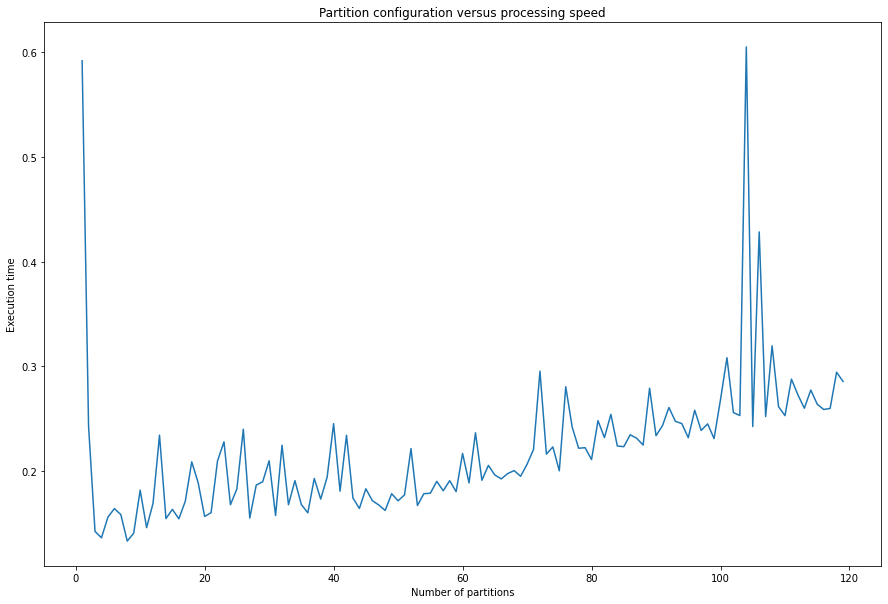

In [15]:
f, a = plt.subplots(figsize=(15,10))

plt.plot([x for x in times.keys()],[x.total_seconds() for x in times.values()])
plt.xlabel('Number of partitions')
plt.ylabel('Execution time')
plt.title('Partition configuration versus processing speed')

It should be clear that the processing time increases as the number of partitions increase. It's almost linear. This may just be that it is better to perform the calculation using one processor instead of many, although, we do see a small decrease initially, with the optimal number being around eight processors). Let's increase the size of the dataset to force Spark to make better use of the parallelism. 

In [16]:
# # Generate a larger DataFrame. 
# df = spark.range(1*1000000)
# df = df.withColumn('fourth', F.col('id') ** 4)

In [19]:
year = 1962
 # spark.read.csv(path, header=True, recursiveFileLookup=True)
try:
    df = spark.read.csv(f'../stocks/{year}/01/02/stocks.csv', header=True, recursiveFileLookup=True)
    df.dtypes
except FileNotFoundError as e:
        print(f'Folder not found: Error {e}')

In [20]:
df.rdd.getNumPartitions()

1

In [23]:
times = {}
for i in range(1, 4):
    st = datetime.now()
    _test_df = df.repartition(i) # Use repartition to set the number of partitions in the dataset.
    _test_df.collect() # Use count to invoke an action on the DataFrame which will execute all manipulations on the DataFrame.
    et = datetime.now()
    times[i] = et-st # Calculate and append the time to process.
    print(f'Busy with iteration {i}')

Busy with iteration 1
Busy with iteration 2
Busy with iteration 3


Let's have a look at the result:

Text(0.5, 1.0, 'Partition configuration versus processing speed for a larger data set')

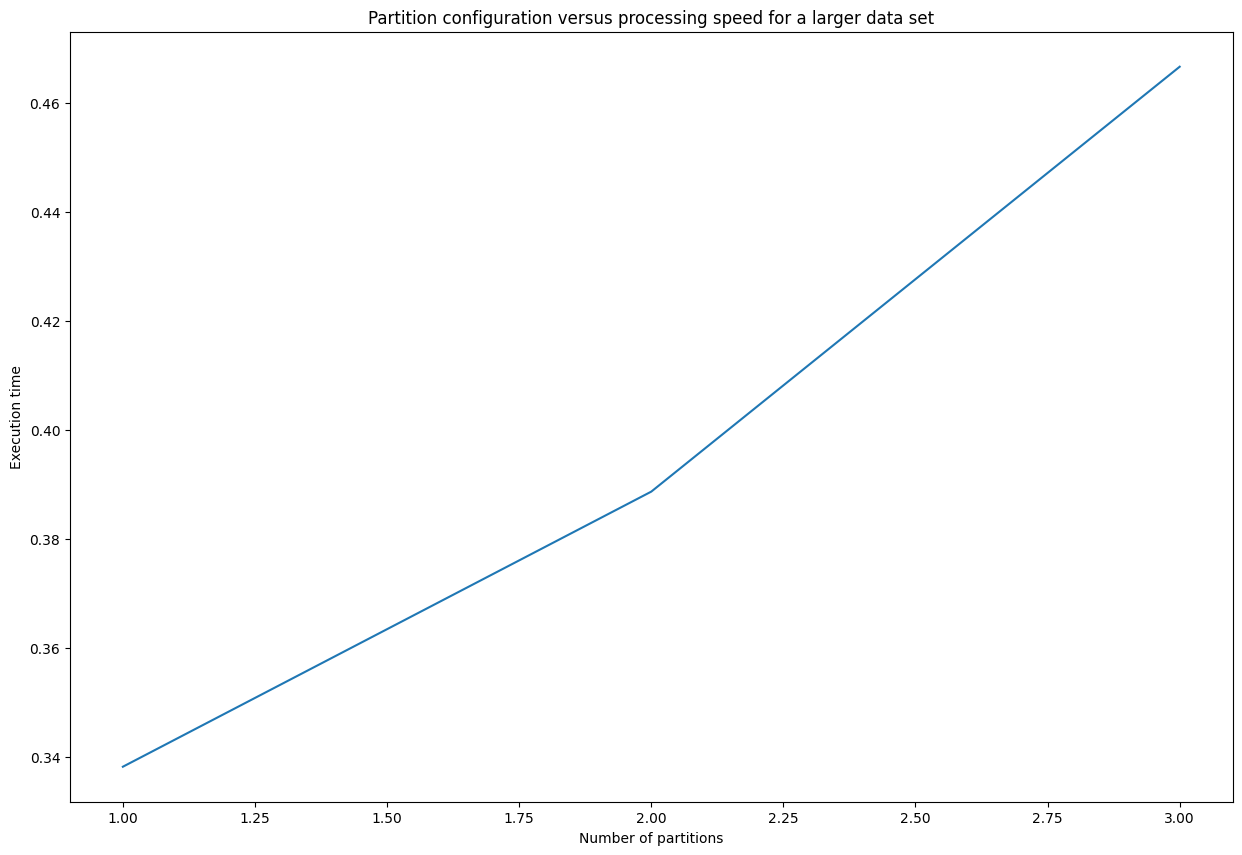

In [24]:
f, a = plt.subplots(figsize=(15,10))

plt.plot([x for x in times.keys()],[x.total_seconds() for x in times.values()])
plt.xlabel('Number of partitions')
plt.ylabel('Execution time')
plt.title('Partition configuration versus processing speed for a larger data set')

Here, the picture is a bit different. There does not seem to be a linear relationship between the number of partitions and execution time. Rather, the execution time is initially quite long. This is followed by the ideal number of partitions and then, again, the execution time increases as the partition number is not ideal anymore. 

It will not always be feasible to test the number of partitions in this way for each dataset. Also, datasets can change in volume or velocity over time. As such, it's best to keep a close eye on the execution time of your data pipelines and transformation notebooks or scripts and do adjustments as they become needed. 

Do note that these run times will differ quite a lot depending on the environment in which you run it. If you run it on a Microsoft Windows machine, it will be quite variable due to Windows having a lot of control over how many resources are allocated to Spark (Java, to be specific, which Spark is executed in), whereas, if you run this on a Unix-based OS, it should be a more reasonable representation. 

## 2. Understand and apply caching and persisting data
Another way that you can boost the performance of your application is by caching or persisting data that you use frequently.

Spark has two APIs to persist or cache data: `cache()` and `persist()`.

`cache()` allows you to store as many partitions in memory as is available. Thus, if you have eight partitions and you have space to partition six of them, you will be able to cache those partitions in memory. You cannot cache partial partitions. Partitions not cached will have to recompute when running your application, which will lead to an application slowdown. 

Let's see this in practice. We create a dummy dataset and apply some complex transformations to the dataset. 

In [19]:
df = spark.range(1*1000000)
df = df.withColumn('tenth', F.col('id') ** 10)

Let's cache the dataset. However, it is only cached when we perform a subsequent action.

In [20]:
df.cache()

DataFrame[id: bigint, tenth: double]

The `count()` method below will invoke an action and, subsequently, cache the result.

We use the `%%time` cell magic to time one run of the whole cell.

In [21]:
%%time 

df.count()

CPU times: user 1.26 ms, sys: 1.86 ms, total: 3.12 ms
Wall time: 1.65 s


1000000

We can now run `count()` again, and check if the result is returned a bit quicker.

In [22]:
%%time

df.count()

CPU times: user 1.11 ms, sys: 2.01 ms, total: 3.12 ms
Wall time: 123 ms


1000000

Caching the data before performing an action on the DataFrame can result in a large performance improvement. In the example above, the data is cached once the `df.count()` action is performed on the dataset, and each subsequent `df.count()` action will have performance improvements. 


Another way of caching data is by using the `persist()` method.

Persist provides slightly more control over how the data are persisted, as you can specify the storage level at which the data should be persisted. Storage levels available are summarised in the table below.

<p align="center">
<img src="https://github.com/Explore-AI/Pictures/blob/c9898b18f293bf350241e158f32a1f2199d5a0bd/data_engineering/transform/optimising_spark/storage_caching.jpg?raw=True",
     alt="storage caching",
     style="padding-bottom=0.5em",
     width=600px/>
<br>
<em> Table 1. Storage levels at which data can be persisted. Credit: Learning Spark 2.0. </em>
</p>

In [23]:
df = spark.range(1*1000000)
df = df.withColumn('tenth', F.col('id') ** 10)

In [24]:
from pyspark.storagelevel import StorageLevel

df.persist(StorageLevel.DISK_ONLY)

DataFrame[id: bigint, tenth: double]

In [25]:
%%time

df.count()

CPU times: user 1.31 ms, sys: 1.95 ms, total: 3.26 ms
Wall time: 101 ms


1000000

In [26]:
%%time

df.count()

CPU times: user 1.38 ms, sys: 2.3 ms, total: 3.68 ms
Wall time: 104 ms


1000000

Hopefully, you'll notice a massive speed-up.

This, again, will depend on the machine that you are using. If you have a solid-state hard drive, it will be a lot faster than caching to a hard disk drive.

## 3. Understand and defend how to use clusters for running Spark applications, with specific reference to EMR/Databricks


### What is a cluster, and is it worth the effort?

Apache Spark is fundamentally a big data processing platform. This means that it will be most powerful when it has access to a lot of computational resources. Running Spark on a single core machine is like putting a small 1.0cc engine into the body of a Ferrari. You have a very powerful framework but without a lot of horsepower to power its execution. 

Giving Spark access to a multicore machine is a great improvement over a single-core machine. Allowing Spark to run multiple threads across more than one core will greatly improve its ability to process big data. Additionally, you get the added benefit of reduced network overhead since you are running all of your processing within a single machine. However, you won't have the ability to scale out to the extent you may achieve with larger computational resources, as you only have a limited number of cores on your stand-alone machine. 

The way to fully utilise Spark is by using large clusters. These clusters can theoretically scale out indefinitely, adding more and more nodes (single CPU machines) as the load/demand for more computational power increases. This means that Spark can utilise its embarrassingly parallel features, enabling it to process terabytes or even petabytes of data on a single cluster. 

### Running Spark clusters is difficult, but cloud providers are there to help

Clusters are clearly the way to go in a big data environment, but that is easier said than done.

From this train, you should gather that there are hundreds of Spark configuration settings that can be tweaked to improve performance, a dozen or more being crucial for great performance. There is no _one-size-fits-all_ answer for cluster configuration, and the configuration will largely depend on the workload, volume, and velocity of the incoming data, as well as the number of consecutive jobs being run on that cluster. 

Managing a Spark cluster is a lot of work. It can be challenging to say the least. That is why most cloud providers have managed Apache Spark instances running on fully managed clusters, for example:
- [Amazon EMR](https://aws.amazon.com/emr/);
- [Instaclustr](https://www.instaclustr.com/products/managed-apache-spark/);
- [Azure HDInsight](https://azure.microsoft.com/en-us/services/hdinsight/);
- [GCP Dataproc](https://cloud.google.com/dataproc); and
- [IBM Analytics for Apache Spark](https://www.ibm.com/analytics/ca/en/technology/cloud-data-services/spark-as-a-service/).

Cloud providers are not the only players in the field of setting up managed clusters for Spark. In 2013, the creators of Spark launched Databricks, a managed Spark service. Databricks takes care of a lot of the challenging configurations that are sometimes a barrier for data engineers or scientists to actually start using Spark. Coming from the creators of Spark, Databricks brings many optimisations not available from cloud providers. 


### Databricks makes running Spark in the cloud simple

Databricks initially started out as a platform that hosts Apache Spark on a managed cluster – a place where data scientists and engineers can transform and manipulate very large datasets without having to think about the underlying infrastructure. In 2017, [Databricks started partnering with one of the largest cloud providers, Microsoft Azure](https://docs.microsoft.com/en-us/azure/databricks/scenarios/what-is-azure-databricks) to increase their reach, and they have since also partnered with AWS and GCP. 

As Databricks started to mature, they have incorporated custom configuration of Apache Spark into their platform, along with developing some open-source tooling: MLFlow, Koalas, and Delta Lake. [MLFlow](https://mlflow.org/) provides machine learning and data science experiment tracking, as well as complete model life cycle management, and has become one of the leading tools data scientists use in model development. [Koalas](https://koalas.readthedocs.io/en/latest/) delivers a 'friendlier' entry into Spark, providing a Pandas API in Spark. [Delta Lake](https://delta.io/) is an abstraction that is built on top of the data lake that allows better management of the underlying data, version control, and structured querying. 

Databricks has evolved to become a complete cloud data platform solution, leveraging the technology developed in Delta Lake to build what Databricks refers to as the lakehouse. The lakehouse is the coming together of the data warehouse and the data lake, or to say it another way, the lakehouse provides a place where you can easily access or move data into your data lake. Delta Lake and the lakehouse connects with your data lake and provides a way to execute analytical queries against semi-structured data in the data lake, without having to transform or move the data into a structured database. 

To further open up Databricks and the Lakehouse to the community outside of data engineers and scientists, Databricks launched Databricks SQL, which enables business users to perform business intelligence and reporting on data residing in the data lake (using the lakehouse). Databricks SQL allows querying data using standard SQL within the Databricks environment and lets you connect any of the latest dashboarding tools via connectors. 

<p align="center">
<img src="https://github.com/Explore-AI/Pictures/blob/3f30c178a057b6e55958cfa0ebfb6de5ffde379b/data_engineering/transform/optimising_spark/lakehouse.png?raw=True",
     alt="Lakehouse",
     style="padding-bottom=0.5em",
     width=600px/>
<br>
<em> Figure 3. How Databricks aims to structure the lakehouse. Credit: Databricks website.</em>
</p>

Since 2019, Databricks has also spent a lot of development and resources to improve the performance of Spark above and beyond the optimisations currently afforded by Apache Spark. These optimisations include features such as custom processing backends and optimisers writing in blazing-fast C or C++. 

It goes without saying that there are advantages to using a service developed by the creators of Spark to perform Spark computing. You will more often than not have the latest and greatest features before they are launched in the open-source version of Spark. Databricks has a [list of reasons](https://databricks.com/spark/comparing-databricks-to-apache-spark) why it's better to use their services.

## 4. Apply the SparkUI


In using Spark, you may have come across the Spark UI, especially if things have started to go wrong.
The Spark UI is a graphical user interface into the workings of the Spark application. You can have a look at the jobs, stages, and tasks, some storage elements, the environment, gain information on the executors, memory usage, and even have a look at the SparkSQL queries that have been executed.

Let's access the Spark UI by calling the SparkSession and following the Spark UI hyperlink.

In [27]:
spark

When you open up the Spark UI, it should land you on a page as shown in Figure 4.

<p align="center">
<img src="https://github.com/Explore-AI/Pictures/blob/3f30c178a057b6e55958cfa0ebfb6de5ffde379b/data_engineering/transform/optimising_spark/spark_ui.jpg?raw=True",
     alt="Spark UI",
     style="padding-bottom=0.5em",
     width=1000px/>
<br>
<em> Figure 4. The Spark UI landing page.</em>
</p>

From this, you can locate the jobs, stages, storage, environment, executors, and sql tabs. We will discuss each in a bit more detail below.

### Jobs and stages

Remember that a Spark application is broken down into jobs, stages, and tasks. The Spark UI allows you access to the application through the Jobs and Stages tabs. You can open each of these tabs, and drill down to an increasing level of detail – down to the task level – and gain insight into various metrics for each task, such as memory usage, disk I/O, execution time, and more. 

The Jobs tab provides a timeline for the execution of a specific job. It shows the time the executor was attached to the cluster (this will be when you started Spark if you are running anything on a local Spark instance). You can also see how long each stage in the job took by inspecting the duration field in the table. This is a crucial place to have a look when you are optimising your applications, since a single long-running stage may indicate inefficiencies that can be optimised. 

<p align="center">
<img src="https://github.com/Explore-AI/Pictures/blob/3f30c178a057b6e55958cfa0ebfb6de5ffde379b/data_engineering/transform/optimising_spark/spark_ui_jobs.jpg?raw=True",
     alt="Spark UI Jobs",
     style="padding-bottom=0.5em",
     width=1000px/>
<br>
<em> Figure 5. An example of an open job in the Spark UI.</em>
</p>

As an example, we open up the third stage of the above job to investigate why it took the longest of all three stages.

Similar to the Jobs tab, the Stages tab provides detailed information into the metrics of all stages run within the Spark instance. Again, it is possible to inspect a specific stage here. Some of the available metrics are:
- the average duration of each task;
- time spent on garbage collection; and
- the number of shuffle bytes.

Irregular values in each of these indicate a specific issue. If the variance in task duration is high, it may indicate that your partitions are skewed. If the time spent on garbage collection is high, it may indicate that your workers do not have enough memory allocated, and high I/O may indicate that data needs to be read from external executors frequently. 

<p align="center">
<img src="https://github.com/Explore-AI/Pictures/blob/3f30c178a057b6e55958cfa0ebfb6de5ffde379b/data_engineering/transform/optimising_spark/spark_ui_stages.jpg?raw=True",
     alt="Spark UI stages",
     style="padding-bottom=0.5em",
     width=1000px/>
<br>
<em> Figure 6. An example of the Stages tab in the Spark UI.</em>
</p>

### Storage


The Storage tab in the Spark UI provides information on tables or DataFrame caches by the application as a result of `cache()` or `persist()`.

For example, we can have a look at one of the tables that we have cached above. 

<p align="center">
<img src="https://github.com/Explore-AI/Pictures/blob/3f30c178a057b6e55958cfa0ebfb6de5ffde379b/data_engineering/transform/optimising_spark/spark_ui_storage.jpg?raw=True",
     alt="Spark UI storage",
     style="padding-bottom=0.5em",
     width=1000px/>
<br>
<em> Figure 7. An example of the cached table above. Here we can see a split into eight partitions, each stored in a deserialised format in memory. </em>
</p>

### Environment

As mentioned above, it is important to properly configure your Spark application. The Environment tab provides more information on the Spark application and the environment within which it is set up. It provides detail into the Java and Scala versions on which Spark is built, Spark, Hadoop, and System properties. Of these, Spark properties are the most important, providing insight into all of the Spark configurations. 

<p align="center">
<img src="https://github.com/Explore-AI/Pictures/blob/3f30c178a057b6e55958cfa0ebfb6de5ffde379b/data_engineering/transform/optimising_spark/spark_ui_environment.jpg?raw=True",
     alt="Spark UI environment",
     style="padding-bottom=0.5em",
     width=1000px/>
<br>
<em> Figure 8. The Spark UI Environment tab. </em>
</p>

### Executors

The Executors tab provides more information on the executors available to the application. This is a relatively straightforward tab, as it provides more detail on the basic statistics for all executors, including resource usage, time in garbage collection, completed, failed, and active tasks, as well as the shuffled data, read and written. 

<p align="center">
<img src="https://github.com/Explore-AI/Pictures/blob/3f30c178a057b6e55958cfa0ebfb6de5ffde379b/data_engineering/transform/optimising_spark/spark_ui_executors.jpg?raw=True",
     alt="Spark UI executors",
     style="padding-bottom=0.5em",
     width=1000px/>
<br>
<em> Figure 9. An example of the Executors tab in the Spark UI. </em>
</p>

### SQL

All queries executed using the SparkSQL interface are first converted back to SparkSQL (even if you write PySpark code).

This tab provides you with insight into all SQL queries that ran within the Spark application. It can also give insight into the specific number of rows that were selected, shuffle data amounts, file sizes, execution times, or other useful statistics. 

<p align="center">
<img src="https://github.com/Explore-AI/Pictures/blob/3f30c178a057b6e55958cfa0ebfb6de5ffde379b/data_engineering/transform/optimising_spark/spark_ui_sql.jpg?raw=True",
     alt="Spark UI SQL",
     style="padding-bottom=0.5em",
     width=600px/>
<br>
<em> Figure 10. An example of the Spark UI SQL tab. </em>
</p>

### Debugging using the Spark UI

It is quite easy to get lost within the Spark UI. It is best to spend some time familiarising yourself with the Spark UI, the metrics that are available there, and most importantly, finding what you are looking for within the Spark UI. The best way to achieve this is by spending time tracing a single task through the Spark UI, in other words, launch a task in Spark and then trace it through the various tabs in the Spark UI. Also look at which stages are computationally the most expensive.

As we have done within this train, you can create mock datasets that you can change to see how those changes impact performance. 

The Spark UI provides transparency into your application to a level that is not typically possible by simply analysing the output of your application. It is important to combine the Spark UI insights with the output from `stdout` and `stderr`. Combining the puzzle pieces from all of the above sources will allow you a full picture. 

## Conclusion

In this train, we have seen how we can bend Spark to our will by not just using it as it comes out of the box, but rather tuning the application to our very specific use case. We have also found some basic optimisations that we can apply to our code, specifically around parallelism. Finally, we introduced the Spark UI, which is an important tool in debugging and improving the performance of your applications. 

## Resources

[Factors to consider when optimising Spark](https://medium.com/datakaresolutions/key-factors-to-consider-when-optimizing-spark-jobs-72b1a0dc22bf)

[More Spark optimisation](https://www.analyticsvidhya.com/blog/2020/10/how-can-you-optimize-your-spark-jobs-and-attain-efficiency-tips-and-tricks/)

[Spark memory management deep dive](https://www.linkedin.com/pulse/apache-spark-memory-management-deep-dive-deepak-rajak/)

[More Spark memory management](https://www.unraveldata.com/apache-spark-and-memory/)

[Spark shuffle partitioning](https://sparkbyexamples.com/spark/spark-shuffle-partitions/)

[How Facebook tunes Spark for large workloads](https://towardsdatascience.com/how-does-facebook-tune-apache-spark-for-large-scale-workloads-3238ddda0830)

[Fine-tuning Spark](https://databricks.com/session_na20/fine-tuning-and-enhancing-performance-of-apache-spark-jobs)

[Partitioning and indexing](https://medium.com/xebia-engineering/spark-3-0-enhancements-and-optimization-94a1cda8f1b1)

[Tuning](https://spark.apache.org/docs/latest/tuning.html)

[What is Databricks? ](https://towardsdatascience.com/what-does-databricks-do-8a6c4ef9071b)